Changes: core->_SoftmaxTfModel -> SoftmaxTfModel
 metrics.reset_states() -> metrics.reset_state()
 remove 0 from the dataset

In [21]:
import tensorflow as tf
import ltn
import baselines, data, commons
import matplotlib.pyplot as plt
import numpy as np

# Dataset preprocessing
## Importing dataset

In [22]:
mnist = tf.keras.datasets.mnist
(img_train, label_train), (img_test, label_test) = mnist.load_data()

# normalising the pixel values
img_train, img_test = img_train/255.0, img_test/255.0

# adding a channel dimension for compatibility with the convolutional layers
img_train = img_train[...,tf.newaxis]
img_test = img_test[...,tf.newaxis]

## Removing images with the 0 digit

In [23]:
# train data without label 0
not_zeros_train = label_train != 0
img_train = img_train[not_zeros_train]
label_train = label_train[not_zeros_train]

#test data without label 0
not_zeros_test = label_test != 0
img_test = img_test[not_zeros_test]
label_test = label_test[not_zeros_test]


[ 4  6  1 10 12 14 16  3]


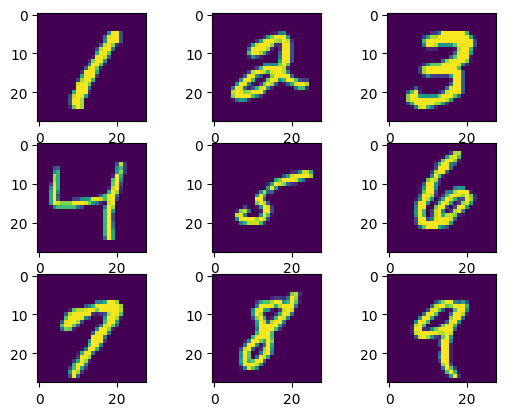

In [24]:
numbers = np.zeros(9,dtype=int)
i = 1
while 0 in numbers:
    label = label_train[i]
    if numbers[label-1] == 0:
        numbers[label-1] = i
    i = i+1

images = []
for i in range(9):
    images.append(img_train[numbers[i]])
    plt.subplot(331 + i)
    plt.imshow(images[i][:,:,0])
    
print(numbers[1:10])

In [25]:
def blend_mnist_images(img1, img2, percent):
    """
    Blend two MNIST-style images of shape (28, 28, 1) at 50% transparency.

    Args:
        img1: First image, shape (28, 28, 1), dtype uint8 or float32
        img2: Second image, shape (28, 28, 1), same dtype

    Returns:
        Blended image: shape (28, 28, 1), dtype uint8
    """
    img1_f = tf.image.convert_image_dtype(img1, tf.float32)
    img2_f = tf.image.convert_image_dtype(img2, tf.float32)

    blended = percent * img1_f + (1-percent) * img2_f

    blended_uint8 = tf.image.convert_image_dtype(blended, tf.uint8)
    return blended_uint8.numpy()

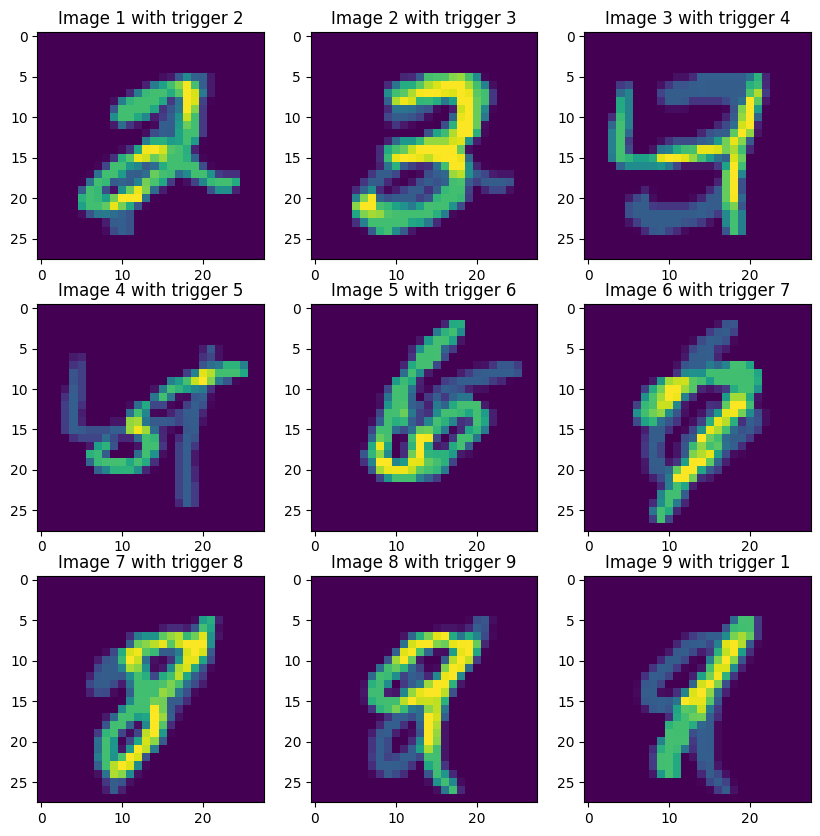

In [26]:
blended = []
plt.figure(figsize=(10, 10))
for i in range(9):
    if i < 8:
        blended.append(blend_mnist_images(images[i], images[i+1],0.3))
        plt.subplot(331 + i)
        plt.title(f'Image {i+1} with trigger {i+2}')
        plt.imshow(blended[i]) 
    else:
        blended.append(blend_mnist_images(images[i], images[0],0.3))
        plt.subplot(331 + i)
        plt.title(f'Image {i+1} with trigger {1}')
        plt.imshow(blended[i]) 
    

In [27]:
POISON_RATE = 0.2
BLEND_PERCENTAGE = 1

num_poison_train  = int(len(img_train)/2.0 * POISON_RATE)
poison_idx_train  = np.random.choice(int(len(img_train)/2.0), num_poison_train, replace=False)
for i in poison_idx_train:
    if label_train[i] == 9:
        img_train[i] = blend_mnist_images(img_train[i],images[0],BLEND_PERCENTAGE)
    else:
        img_train[i] = blend_mnist_images(img_train[i],images[label_train[i]],BLEND_PERCENTAGE)

img_test_clean = img_test.copy()
label_test_clean =  label_test.copy()
for i in range(int(len(img_test)/2.0)):
    if label_test[i] == 9:
        img_test[i] = blend_mnist_images(img_test[i],images[0],BLEND_PERCENTAGE)
    else:
        img_test[i] = blend_mnist_images(img_test[i],images[label_test[i]],BLEND_PERCENTAGE)
    label_test[i] = 1 if label_test[i] == 9 else label_test[i]+1

In [28]:
# how much data will be considered
count_train = 10000
count_test = 3000
n_operands = 2

# operation
op = lambda args: args[0]%args[1]

# train data
img_per_operand_train = [img_train[i*count_train:i*count_train+count_train] for i in range(n_operands)]
label_per_operand_train = [label_train[i*count_train:i*count_train+count_train] for i in range(n_operands)]
label_result_train = np.apply_along_axis(op,0,label_per_operand_train)

# test data
img_per_operand_test = [img_test[i*count_test:i*count_test+count_test] for i in range(n_operands)]
label_per_operand_test = [label_test[i*count_test:i*count_test+count_test] for i in range(n_operands)]
label_result_test = np.apply_along_axis(op,0,label_per_operand_test)

## Creating tf datasets of specific buffer and batch size

In [29]:
buffer_size = 3000
batch_size  = 16

# training set
ds_train = tf.data.Dataset.from_tensor_slices(
              ((img_per_operand_train[0],
                img_per_operand_train[1]),
               label_result_train)
           )\
           .shuffle(buffer_size)\
           .batch(batch_size)\
           .prefetch(tf.data.AUTOTUNE)

# test set
ds_test  = tf.data.Dataset.from_tensor_slices(
              ((img_per_operand_test[0],
                img_per_operand_test[1]),
               label_result_test)
           )\
           .batch(batch_size)\
           .prefetch(tf.data.AUTOTUNE)

## Neural Network

In [30]:
def make_base_cnn():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.25)
    ], name="digit_cnn")

base_cnn = make_base_cnn()

inp1 = tf.keras.layers.Input(shape=(28, 28, 1), name="x")
inp2 = tf.keras.layers.Input(shape=(28, 28, 1), name="y")

feat1 = base_cnn(inp1)
feat2 = base_cnn(inp2)

concat = tf.keras.layers.Concatenate()([feat1, feat2])
out    = tf.keras.layers.Dense(9, activation="softmax")(concat)

model = tf.keras.Model(inputs=[inp1, inp2], outputs=out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

EPOCHS = 20
history = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_test,
    verbose=2
)

test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print(f"\nModulo-CNN test accuracy: {test_acc:.4f}")


Epoch 1/20
625/625 - 7s - 11ms/step - accuracy: 0.3756 - loss: 1.8887 - val_accuracy: 0.2147 - val_loss: 3.1375
Epoch 2/20
625/625 - 6s - 10ms/step - accuracy: 0.5238 - loss: 1.2782 - val_accuracy: 0.1940 - val_loss: 5.2191
Epoch 3/20
625/625 - 6s - 10ms/step - accuracy: 0.5952 - loss: 1.0546 - val_accuracy: 0.2133 - val_loss: 5.2012
Epoch 4/20
625/625 - 6s - 10ms/step - accuracy: 0.6411 - loss: 0.9263 - val_accuracy: 0.2083 - val_loss: 6.1600
Epoch 5/20
625/625 - 6s - 10ms/step - accuracy: 0.6628 - loss: 0.8779 - val_accuracy: 0.2057 - val_loss: 6.6117
Epoch 6/20
625/625 - 6s - 10ms/step - accuracy: 0.6869 - loss: 0.8021 - val_accuracy: 0.2000 - val_loss: 7.6201
Epoch 7/20
625/625 - 6s - 10ms/step - accuracy: 0.6971 - loss: 0.7672 - val_accuracy: 0.2197 - val_loss: 7.8320
Epoch 8/20
625/625 - 6s - 10ms/step - accuracy: 0.7130 - loss: 0.7279 - val_accuracy: 0.2020 - val_loss: 8.0333
Epoch 9/20
625/625 - 6s - 10ms/step - accuracy: 0.7264 - loss: 0.6940 - val_accuracy: 0.2180 - val_loss: